In [4]:
ray.shutdown()

In [1]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import numpy as np
from scipy import optimize
import os
import json
from matplotlib import pyplot as plt
import matplotlib

from collections import defaultdict

In [2]:
param_names = [
#                 'threshold',
#                 'succ_dist',
#                 'penalty',  
#                 'logit_scale',
    
                 'num_trains',
#                 'policy_lr', 
                 'qf_lr',
#                 'soft_update',
#                 'num_trains',
        
#                 'temp',
#                 'cql_weight',
#                 'sparse_reward',
#                 'demo_path_proportions',
    
    
#                 'random_proj'
#                 'demo_paths',
#                 'threshold',
#                 'epsilon',
               ]
param_full_names = [
#                 'env_kwargs/config/oracle_kwargs/threshold',
#                 'env_kwargs/config/env_kwargs/success_dist',
#                 'env_kwargs/config/input_penalty',
#                 'exploration_kwargs/logit_scale',
    
                 'algorithm_args/num_trains_per_train_loop',
#                 'trainer_kwargs/policy_lr',
                 'qf_lr',
#                 'trainer_kwargs/soft_target_tau',
#                 'algorithm_args/num_trains_per_train_loop',
#                 'trainer_kwargs/temp',
#                 'trainer_kwargs/min_q_weight',
    
#                 'env_kwargs/config/sparse_reward',
#                 'demo_path_proportions'
    
#                 'env_kwargs/config/apply_projection'
#                 'demo_paths/0',
#                 'env_kwargs/config/oracle_kwargs/threshold',
#                 'env_kwargs/config/oracle_kwargs/epsilon'
                    ]
result_names = [
                'expl_num_correct',
                'expl_successes',
#                 'eval_successes',
    
#                 'expl_bad_contact',
#                 'eval_bad_contact',
    
#                 'expl_reward',
#                 'eval_reward',
    
                'expl_noop',
#                 'eval_noop',
    
#                 'expl_cos_error',
#                 'eval_cos_error',
    
                'qf_loss',
                'Q_values_mean',
                'Q_values_std',
#                 'Q_values_min'
#                 'Policy_loss',
#                 'log_pi_mean',
#                 'log_pi_std',
#                 'Q_targets_mean',
#                 'alpha',
                ]
result_full_names = [
                     'exploration/env_infos/num_correct_Mean',
#                      'evaluation/env_infos/num_correct_Mean',
    
#                      'exploration/path_length_Mean',
                     'exploration/env_infos/final/task_success_Mean',
#                      'evaluation/env_infos/final/task_success_Mean',
    
#                      'exploration/env_infos/bad_contact_Mean',
#                      'evaluation/env_infos/bad_contact_Mean',
    
#                     'exploration/Rewards_Mean',
#                     'evaluation/Rewards_Mean',
    
                     'exploration/env_infos/noop_Mean',
#                      'evaluation/env_infos/noop_Mean',

#                      'exploration/env_infos/cos_error_Mean',
#                      'evaluation/env_infos/cos_error_Mean',
    
                    'trainer/QF_Loss',
                    'trainer/Q_Predictions_Mean',
                    'trainer/Q_Predictions_Std',
#                     'trainer/Q1_Predictions_Min'
#                     'trainer/Policy_Loss',
#                     'trainer/Log_Pis_Mean',
#                     'trainer/Log_Pis_Std',
#                     'trainer/Q_Targets_Mean',
#                     'trainer/Alpha',
                    ]
tests = ['a-test/']

In [85]:
paths = sum([[(os.path.join(path,run),test) for run in os.listdir(path)] 
             for path,test in [(os.path.join(os.path.abspath(''),'logs',test,),test) for test in tests]],[]) 
paths = sorted(paths, key=lambda x: x[0])
# import ray
# ray.init()
# @ray.remote(num_cpus=1,num_gpus=0)
class Reader:
    def read(self,paths):
        dfs = []
        for path,test in paths:
            try:
                df = pd.read_csv(os.path.join(path,'pretrain.csv'))
                dfs.append(df)
            except:
                continue
        return dfs
    
# num_workers = 10
# readers = [Reader.remote() for i in range(num_workers)]
# dfs = [reader.read.remote(path_sect) for reader,path_sect in zip(readers,np.array_split(paths,num_workers))]
# dfs = [ray.get(read) for read in dfs]
# ray.shutdown()
# dfs = sum(dfs,[])
dfs = Reader().read(paths)
for df in dfs:
    df.columns = df.columns.get_level_values(0)

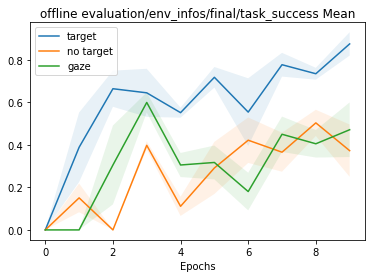

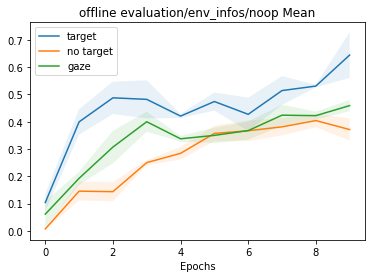

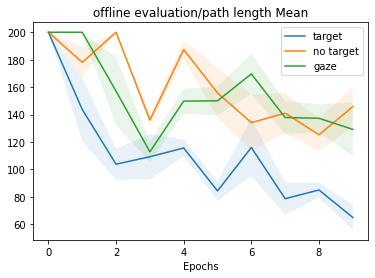

In [91]:
i1 = [2, 3, 4]
i2 = [5, 6, 7]
i3 = [8, 9, 10]
index_sets = [i1, i2, i3]
l1 = 'target'
l2 = 'no target'
l3 = 'gaze'
labels = [l1, l2, l3]
metrics = ['evaluation/env_infos/final/task_success Mean',
           'evaluation/env_infos/noop Mean',
           'evaluation/path length Mean']
window = 1

def smooth(x):
    return np.convolve(x, np.ones(window), 'valid') / window

def plot():
    for metric in metrics:
        plt.figure()
        for indices, label in zip(index_sets, labels):
            data = [smooth(dfs[i][metric]) for i in indices]
            std_error = np.std(data, axis=0) / np.sqrt(len(indices)) 
            mean = np.mean(data, axis=0)
            plt.plot(mean, label=label)
            plt.fill_between(np.arange(len(mean)), mean-std_error, mean+std_error, alpha=0.1)
        plt.title('offline ' + metric)
        plt.xlabel('Epochs')
        plt.legend()
        
plot()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


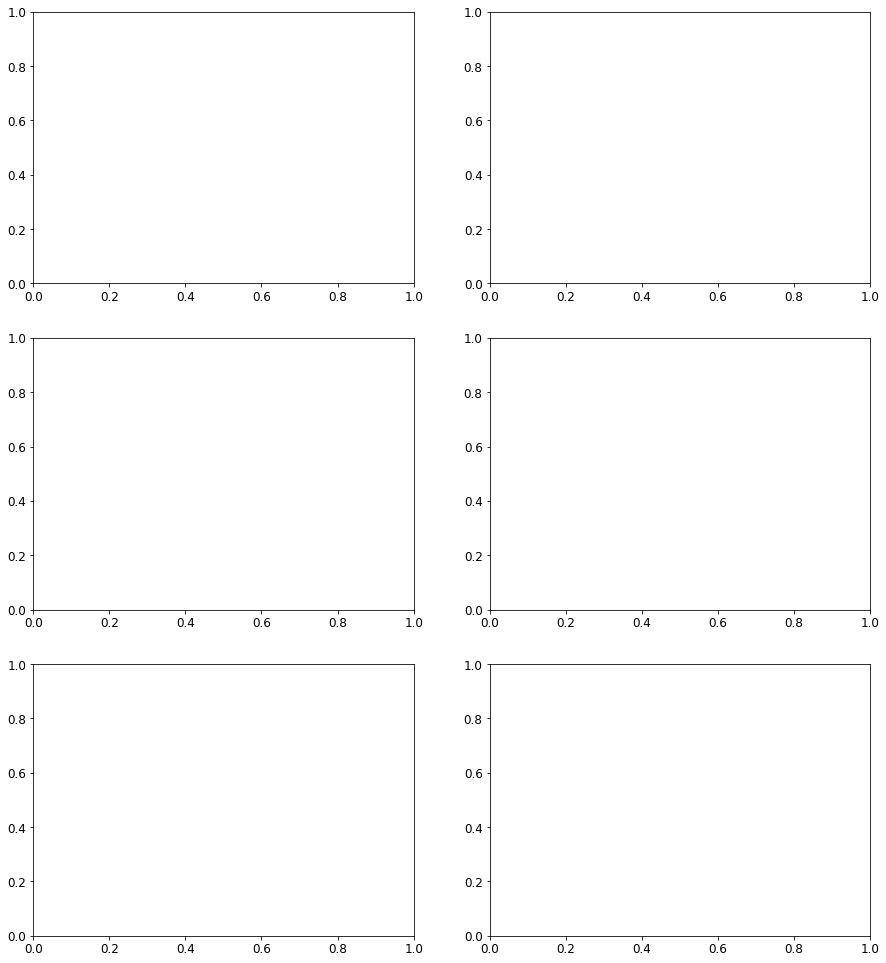

In [260]:
alphas = dict(zip(result_names,[.01]*len(result_names)))
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(nrows=(len(result_names)+1)//2,ncols=2,figsize=(15,5*(len(result_names)+1)//2))
axs = axs.flatten()
idx = pd.IndexSlice

# slice_df = slice_df.drop(columns=[(5e-4,1e-2),(1e-3,1e-2)])
# print(slice_df.head())

for (name,alpha),ax in zip(alphas.items(),axs):
    try:
        graph_df = df.loc[:,idx[:,:,:,name]]
#         graph_df = df.loc[:,idx['500_fail_demos',:,:,:,name]]
#         graph_df = df.loc[:,[(.001,.1,.1,name),(.001,1,.3,name)]]

#         graph_df = graph_df.drop(columns=[(1e-3,5e-5,1e-2)])
        graph_df.columns = graph_df.columns.droplevel([c for c in graph_df.columns.names
                                                       if graph_df.columns.get_level_values(c).unique().size == 1])
        graph_df.ewm(alpha=alpha).mean().plot(ax=ax,title=name)
#         print(graph_df.ewm(alpha=alpha).mean().loc[10])
    except:
        continue
#     if 'success' in name:
#         for key,value in success.items():
#             ax.plot(range(600),[value]*600,label=f"default threshold={key}")
#     if 'contact' in name:
#         for key,value in bad_contact.items():
#             ax.plot(range(600),[value]*600,label=f"default threshold={key}")
#     elif 'noop' in name:
#         for key,value in noop.items():
#             ax.plot(range(600),[value]*600,label=f"default threshold={key}")
#     elif 'cos' in name:
#         for key,value in noop.items():
#             ax.plot(range(600),[value]*600,label=f"default threshold={key}")
#     ax.legend()

In [ ]:
alphas = dict(zip(result_names,[.01]*len(result_names)))
font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(nrows=(len(result_names)+1)//2,ncols=2,figsize=(15,5))
axs = axs.flatten()
idx = pd.IndexSlice
test_name_map = {'experiment2-laptop-dqn':'dqn','experiment2-laptop-sac':'sac',
                 'experiment2-laptop-dqn-cql':'cql-dqn','experiment2-laptop-cql':'cql-sac',}
metric_name_map = {'expl_successes':'Success Rate','expl_noop': 'User Noop Rate'}

# slice_df = slice_df.drop(columns=[(5e-4,1e-2),(1e-3,1e-2)])
# print(slice_df.head())


for (name,alpha),ax in zip(alphas.items(),axs):
#     try:
        mean_graph = df_mean.loc[:,idx[:,:,:,:,name]]
        std_graph = df_std.loc[:,idx[:,:,name]]
#         graph_df = df.loc[:,[(.001,.1,.1,name),(.001,1,.3,name)]]

#         graph_df = graph_df.drop(columns=[(1e-3,5e-5,1e-2)])
        mean_graph.columns = mean_graph.columns.droplevel([c for c in mean_graph.columns.names
                                                           if mean_graph.columns.get_level_values(c).unique().size == 1])
        mean_graph = mean_graph.ewm(alpha=alpha).mean()
        std_graph.columns = std_graph.columns.droplevel([c for c in std_graph.columns.names
                                                         if std_graph.columns.get_level_values(c).unique().size == 1])
        std_graph = std_graph.ewm(alpha=alpha).mean()
        for (col_names,mean),(_col_names,std) in zip(mean_graph.iteritems(),std_graph.iteritems()):
            ax.fill_between(x=range(mean.size),y1=np.maximum(0,mean-std),y2=np.minimum(1,mean+std),alpha=.3)
            ax.plot(range(mean.size),mean,label=f"({not col_names[0]},{test_name_map[col_names[1]]})")
        ax.set_title(metric_name_map[name])
        ax.set_xlabel("Epochs")
#         ax.legend(loc=3,fontsize='xx-small',title_fontsize='xx-small',title="user input penalty,algorithm")
        ax.legend(loc=3,fontsize='xx-small',title_fontsize='xx-small',title="user input penalty,algorithm")
#     except:
#         continue

# plt.savefig('experiment2_laptop_full.png')

In [47]:
defaults = { demo[-17:-4]:np.load(os.path.join(os.path.abspath(''),'demos',demo),allow_pickle=True)
             for demo in os.listdir(os.path.join(os.path.abspath(''),"demos")) if f"thr_" in demo and "OneSwitch" in demo}
# defaults = [np.load(os.path.join(os.path.abspath(''),'demos',f"LightSwitch_usermodel_1001.npy"),allow_pickle=True)]

In [48]:
defaults.keys()

dict_keys(['thr_.5_eps_50', 'thr_.5_eps_25', '_thr_.5_eps_0', '_thr_.0_eps_0', '_thr_.2_eps_0'])

In [49]:
success = {key:np.mean([path['env_infos'][-1]['task_success'] for path in paths])
           for key,paths in defaults.items()}
bad_contact = {key:np.mean([path['env_infos'][-1]['bad_contact'] for path in paths])
           for key,paths in defaults.items()}
noop = {key:np.mean(sum([[info['noop'] for info in path['env_infos']] for path in paths],[]))
           for key,paths in defaults.items()}
cos = {key:np.mean(sum([[info['cos_error'] for info in path['env_infos']] for path in paths],[]))
           for key,paths in defaults.items()}

In [50]:
success

{'thr_.5_eps_50': 1.0,
 'thr_.5_eps_25': 1.0,
 '_thr_.5_eps_0': 1.0,
 '_thr_.0_eps_0': 1.0,
 '_thr_.2_eps_0': 0.99375}

In [51]:
noop

{'thr_.5_eps_50': 0.5710240436595788,
 'thr_.5_eps_25': 0.6327110825018775,
 '_thr_.5_eps_0': 0.6814617849594328,
 '_thr_.0_eps_0': 0.7638537347191556,
 '_thr_.2_eps_0': 0.7429401323220913}

In [22]:
params_2_test = defaultdict(list)

for path in paths:
    test_name = os.path.split(os.path.split(path)[0])[1]     

    params = []
    with open(os.path.join(path,'variant.json'),) as f:
        all_params = json.load(f) 
    for name,full_name in zip(param_names,param_full_names):
        param = all_params
        for key in full_name.split('/'):
            param = param.get(key,0)
        params.append(param)
    params = tuple(params)
    params_2_test[params].append(test_name)
    

TypeError: expected str, bytes or os.PathLike object, not tuple

In [32]:
params_2_test

defaultdict(list,
            {(1000,): ['run1', 'run0', 'run4'],
             (1,): ['run5', 'run2', 'run3']})

In [67]:
trajs = [np.load(os.path.join(os.path.abspath(''),'eval_paths1',f"{run[3:]}_eval_paths.npy"),allow_pickle=True)
             for run in ['run14']]

In [68]:
print(len(trajs[0]))

18


In [85]:
pos = sum([[tr['observations'][:,-20:-17] for tr in traj[:40]] for traj in trajs],[])
pos1 = pos[0]
mean_pos = np.mean(pos1,axis=0)
max_extent = np.max(np.linalg.norm(pos1-mean_pos,axis=1))
pos1 = (pos1-mean_pos)/max_extent

pos2 = pos[1]
mean_pos = np.mean(pos2,axis=0)
max_extent = np.max(np.linalg.norm(pos2-mean_pos,axis=1))
pos2 = (pos2-mean_pos)/max_extent

# pos = np.mean(pos,axis=0)
reg_pos = []
for traj in pos:
    mean_pos = np.mean(traj,axis=0)
    max_extent = np.max(np.linalg.norm(traj-mean_pos,axis=1))
    traj = (traj-mean_pos)/max_extent
    reg_pos.append(traj)
pos = np.array([np.mean([sample[i] for sample in reg_pos if len(sample) > i],axis=0) for i in range(200)])


NameError: name 'trajs' is not defined

In [70]:
# a = .15
# b = .3
# c = .6

In [71]:
dpos = [tr['observations'][:,-20:-17] for tr in defaults[0]]
dpos1 = dpos[0]
mean_pos = np.mean(dpos1,axis=0)
max_extent = np.max(np.linalg.norm(dpos1-mean_pos,axis=1))
dpos1 = (dpos1-mean_pos)/max_extent

dreg_pos = []
for traj in dpos:
    mean_pos = np.mean(traj,axis=0)
    max_extent = np.max(np.linalg.norm(traj-mean_pos,axis=1))
    traj = (traj-mean_pos)/max_extent
    dreg_pos.append(traj)
dpos = np.array([np.mean([sample[i] for sample in dreg_pos if len(sample) > i],axis=0) for i in range(200)])


In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

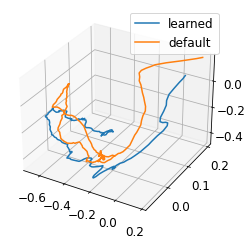

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*list(zip(*pos)),label='learned')
ax.plot(*list(zip(*dpos)),label='default')
ax.legend()

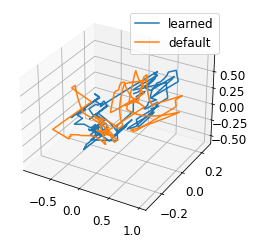

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*list(zip(*pos1)),label='learned')
ax.plot(*list(zip(*dpos1)),label='default')
ax.legend()

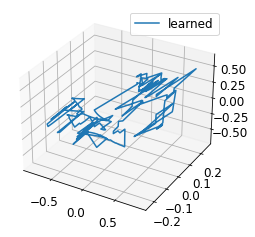

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*list(zip(*pos2)),label='learned')
# ax.plot(*list(zip(*dpos2)),label='default')
ax.legend()